## Macro EDA:


### Things to Consider/Reminders:
* housing market is influenced by the economy, but regions can become "hot" leading to overpriced properties.
* find or create one feature for every type of measurement that a set of similar features is representing (ie. one feature/meta-feature for location, one for size of unit, etc.) 

## Import Libraries & Data

In [27]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import seaborn as sns
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn import svm
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline


In [28]:
df = pd.read_csv("./merged_w_state_build_year_2017-05-28.csv", parse_dates=['timestamp'], index_col=False)
macro_df = pd.read_csv("../Sberbank/macro.csv", parse_dates=['timestamp'], index_col=False)

In [48]:
gdp_feats = ['gdp_quart_growth', 'gdp_quart', 'balance_trade_growth',
            'cpi', 'deposits_growth', 'ppi', 
            'balance_trade', 'micex_rgbi_tr', 'rts', 'micex', 'brent', 
            'eurrub', 'usdrub', 'micex_cbi_tr', 
            'fixed_basket','oil_urals', 'price_doc']

gdp_df = df[gdp_feats].dropna()

### Functions for Scaling/Normalizing/Reshaping

In [49]:
# rescale data using the mean and sd 
def rescale(feature):
    return feature.apply(lambda x: (x - np.mean(x))/np.std(x))

# # normalize data
# from sklearn.preprocessing import Normalizer

def normalize(feature):
    return feature.apply(lambda x: (x-np.min(x))/(np.max(x)-np.min(x)))

### Functions for Rolling Statistics on Time-Series

In [50]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12,center=False).mean()
    rolstd = timeseries.rolling(window=12,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

In [51]:
important_features = ['id', 'full_sq', 'life_sq', 'floor',
                      'max_floor', 'material', 'build_year',
                      'num_room', 'kitch_sq', 'state', 'area_m',
                      'price_doc', 'gdp_quart', 'deposits_value', 
                      'deposits_growth', 'deposits_rate', 'mortgage_value',
                      'mortgage_growth', 'mortgage_rate', 'salary',
                      'unemployment', 'employment',  'oil_urals',
                      'stadium_km', 'floor', 'max_floor', 'metro_min_avto',
                      'build_year', 'cafe_count_5000_price_high', 'num_room',
                      'radiation_km',
                      'green_zone_km', 'industrial_km', 'indust_part',
                      'cpi', 'cafe_count_5000', 'cafe_count_1500_price_high',
                      'cafe_count_5000_price_500', 'cafe_count_2000_price_2500',
                      'kitch_sq', 'max_floor', 'trc_sqm_5000', 
                      'office_sqm_1000', 'trc_sqm_1500', 'office_sqm_500', 'cpi', 
                      'office_sqm_5000', 'ID_railroad_terminal', 'office_sqm_1500', 
                      'ekder_male', 'raion_popul', 'price_doc']

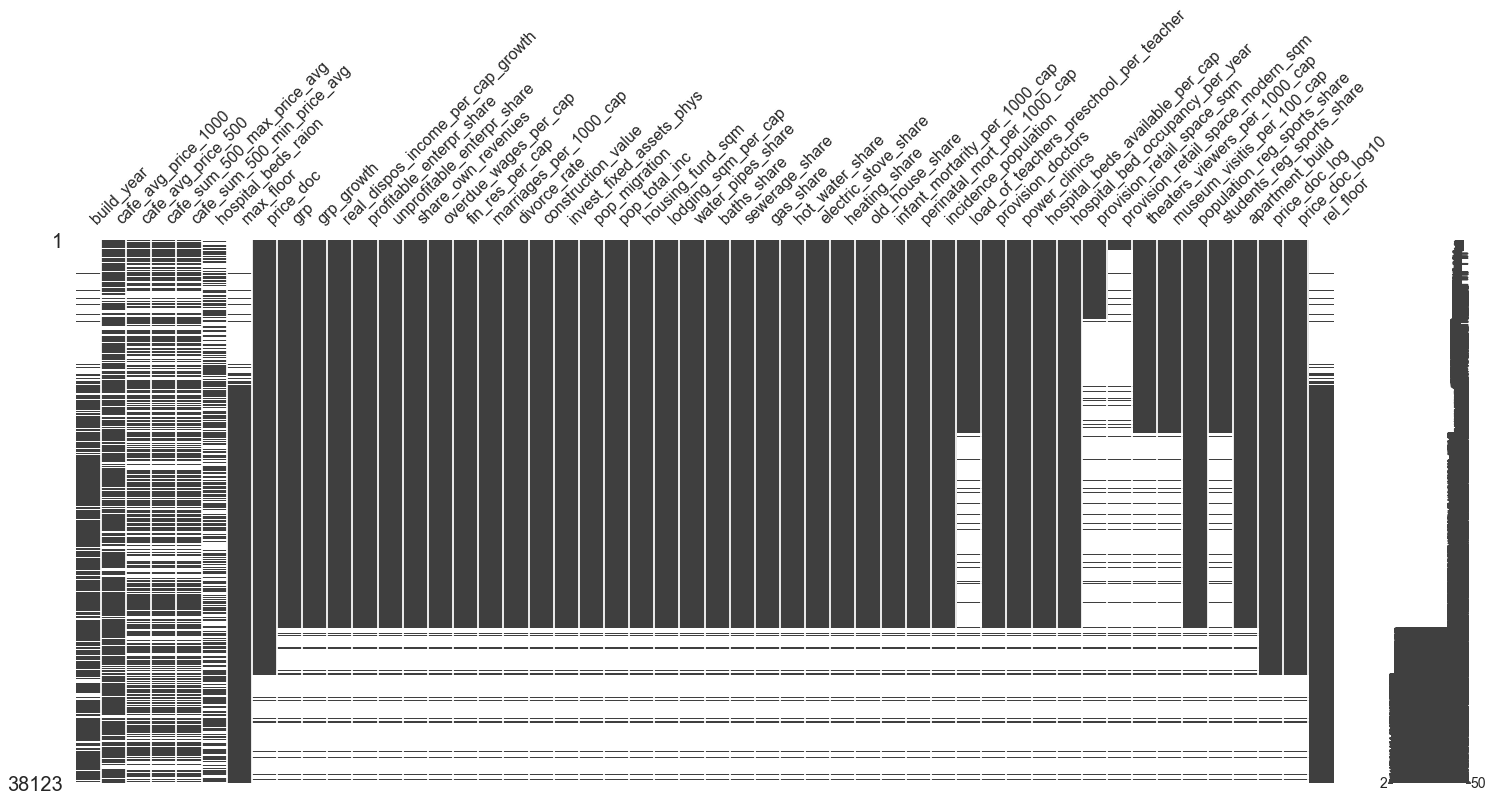

In [52]:
import missingno as msno

df.set_index('timestamp')
filtered_data = msno.nullity_filter(df, filter='bottom', n=50, p=0.99) # or filter='top'

msno.missingno.matrix(filtered_data)

#### Distribution of different GDP Features

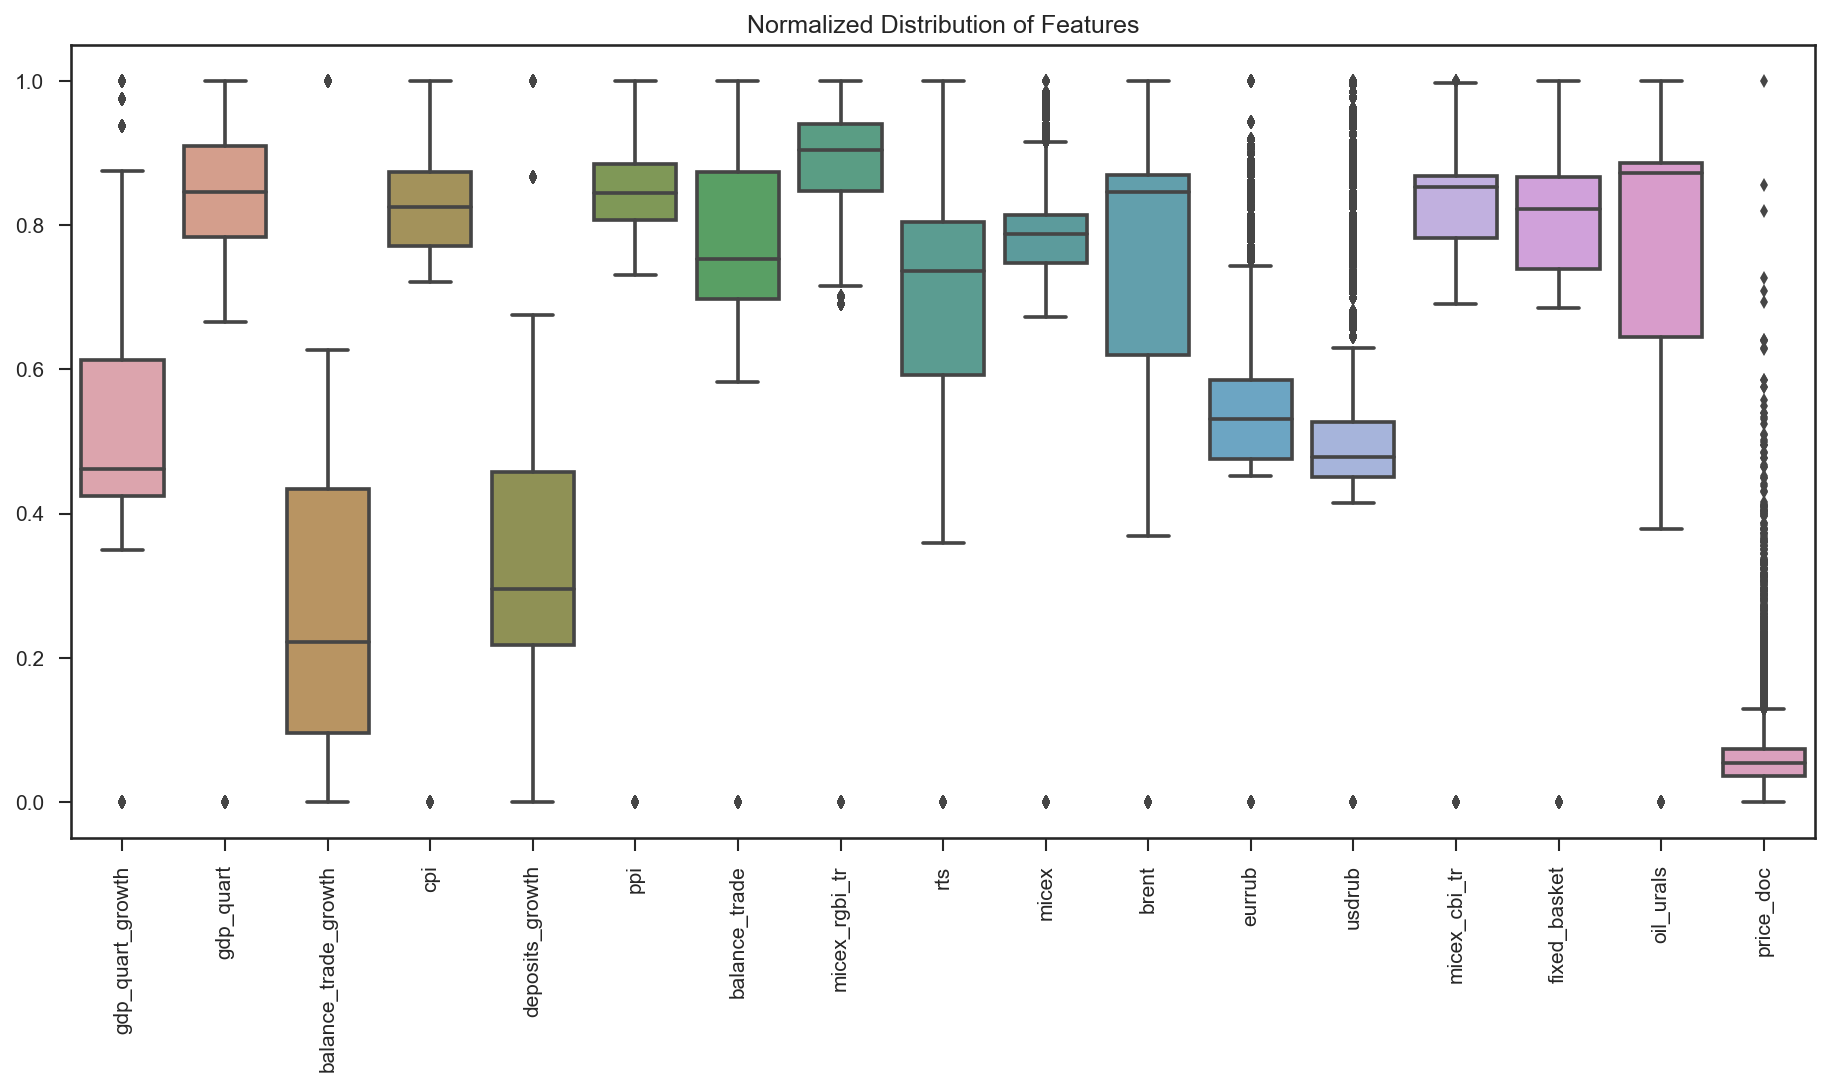

In [53]:
plt.figure(figsize=(15,7),dpi=150)
plt.title('Normalized Distribution of Features')
sns.set_style("ticks")
sns.boxplot(normalize(gdp_df),saturation=0.5) # plot scale
plt.xticks(rotation='vertical')
plt.show()

### Any relationships between the variables?

In [54]:
# feature correlation per day with imputed medians
feature_corr = abs(gdp_df.corr()['price_doc']).sort_values(ascending=False) 

## Time-Series Analysis

In [57]:
print 'Start Date for Null gdp_quart: {0}'.format(macro_df.loc[macro_df['gdp_quart'].isnull(), 'timestamp'].min())
print 'End Date for Null gdp_quart: {0}'.format(macro_df.loc[macro_df['gdp_quart'].isnull(), 'timestamp'].max())

Start Date for Null gdp_quart: 2010-01-01 00:00:00
End Date for Null gdp_quart: 2010-03-31 00:00:00


In [70]:
norm_gdp = [normalize(gdp_df[feature]) for feature in gdp_df.columns]

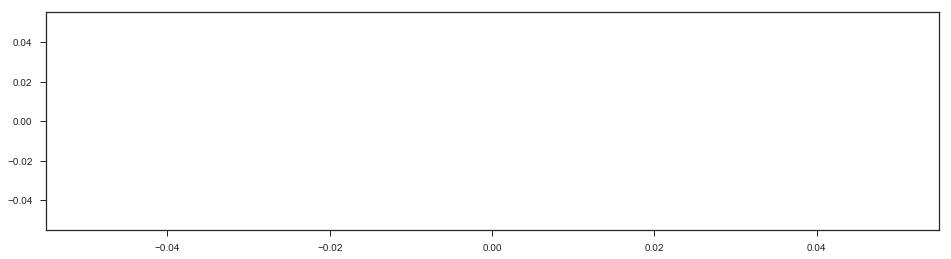

In [73]:

plt.figure(figsize=(16, 4))
plt.plot(norm_gdp)
plt.show()

This needs to be cleaned up with rolling mean windows

### Price smoothed out to better find trends

In [62]:
gdp_rolling = gdp_df.rolling(window=10, center=True).mean()

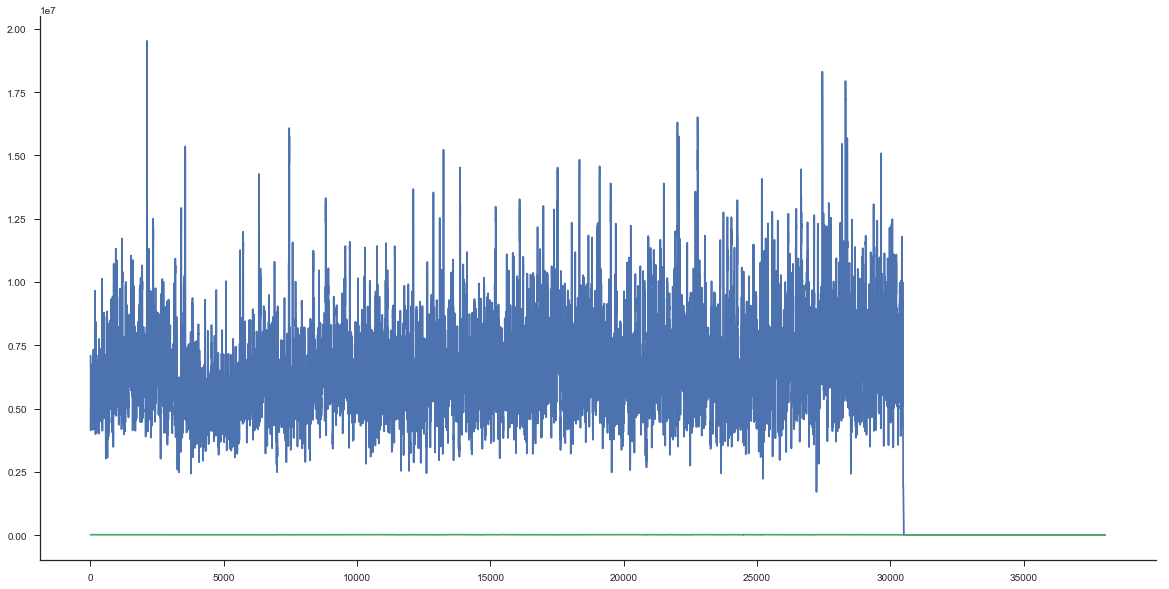

In [72]:
plt.figure(figsize=(20, 10))
plt.plot(gdp_rolling['price_doc'])
plt.plot(gdp_rolling['gdp_quart'])
sns.despine()
plt.show()

In [63]:
ts_log = norm_gdp['price_doc_log']

moving_avg = ts_log.rolling(window=45).mean()

# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels)



plt.figure(figsize=(14,7), dpi=200)
sns.set(style="ticks")
plt.xlabel('Date')
plt.xticks()
plt.ylabel('Deviation %')
line1 = sns.tsplot(norm_gdp['price_doc_log'], color='grey', alpha=0.3, legend=True)
line2 = sns.tsplot(moving_avg, color='red', alpha=0.8, lw=2)
line3 = sns.tsplot(norm_gdp['ppi'].rolling(window=30).mean(), lw=2, color='blue', alpha=0.7) 
line4 = sns.tsplot(norm_gdp['cpi'].rolling(window=30).mean(), lw=2, color='green', alpha=0.7)
# snplt.tsplot(norm_gdp['gdp_quart'], color='red')
plt.grid(False, 'major', 'y', ls='--', lw=.1, c='black')
plt.legend(handles=[line1, line2,line3, line4])
plt.show()


KeyError: 'price_doc_log'

In [ ]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

### Log + 1 of CPI vs. PPI vs. Price

In [ ]:
plt.figure(figsize=(17, 6),dpi=80)
plt.plot(gdp_rolling['cpi'], color='green')
plt.plot(gdp_rolling['ppi'], color='blue')
plt.plot(gdp_rolling['price_doc_log'], color='red')
plt.show()

In [ ]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(120)
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

In [ ]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, freq=90)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10, 10),dpi=100)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

NameError: name 'ts_log' is not defined

In [24]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

#Plot ACF: 
plt.figure(figsize=(20,5))
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

NameError: name 'ts_log_diff' is not defined

In [25]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.figure(figsize=(18,6))
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red', alpha=0.6)
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

NameError: name 'ts_log' is not defined

Euro to Ruble has a slightly strong correlation, so let's remove USD for now.

### Euro to Ruble

In [ ]:
plt.figure(figsize=(20, 10))
sns.set_style("ticks")
sns.tsplot(norm_gdp['eurrub'], color='red', alpha=0.6)
plt.plot()
sns.tsplot(norm_gdp['price_doc_log'], color='blue', alpha=0.6, err_style='ci_band', ci=4)
plt.grid(False, 'major', 'y', ls='--', lw=0.6, c='gray')
plt.show()